# HairFast Inference Notebook

## Prepare Environment and Download HairFast Code

In [ ]:
#@title Clone HairFast Repo and Install Ninja { display-mode: "form" }
## install ninja
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

## clone repo
!git clone https://github.com/AIRI-Institute/HairFastGAN
%cd HairFastGAN

/content/HairFastGAN


In [ ]:
#@title Install other packages and Download pretrained models { display-mode: "form" }
from concurrent.futures import ProcessPoolExecutor


def install_packages():
    !pip install pillow==10.0.0 face_alignment dill==0.2.7.1 addict fpie \
      git+https://github.com/openai/CLIP.git -q
    !pip install fastcore -U



def download_models():
    !git clone https://huggingface.co/AIRI-Institute/HairFastGAN
    !cd HairFastGAN && git lfs pull && cd ..
    !mv HairFastGAN/pretrained_models pretrained_models
    !mv HairFastGAN/input input
    !rm -rf

install_packages()
download_models()

  Preparing metadata (setup.py) ... done
fatal: destination path 'HairFastGAN' already exists and is not an empty directory.


In [ ]:
#@title Image drawing and downloader { display-mode: "form" }
import requests
from io import BytesIO
from PIL import Image
from functools import cache

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as T
import torch
%matplotlib inline


def to_tuple(func):
    def wrapper(arg):
        if isinstance(arg, list):
            arg = tuple(arg)
        return func(arg)
    return wrapper


@to_tuple
@cache
def download_and_convert_to_pil(urls):
    pil_images = []
    for url in urls:
        response = requests.get(url, allow_redirects=True, headers={"User-Agent": "Mozilla/5.0"})
        img = Image.open(BytesIO(response.content))
        pil_images.append(img)
        print(f"Downloaded an image of size {img.size}")
    return pil_images


def display_images(images=None, **kwargs):
    is_titles = images is None
    images = images or kwargs

    grid = gridspec.GridSpec(1, len(images))
    fig = plt.figure(figsize=(20, 10))

    for i, item in enumerate(images.items() if is_titles else images):
        title, img = item if is_titles else (None, item)

        img = T.functional.to_pil_image(img) if isinstance(img, torch.Tensor) else img
        img = Image.open(img) if isinstance(img, str | Path) else img

        ax = fig.add_subplot(1, len(images), i+1)
        ax.imshow(img)
        if title:
            ax.set_title(title, fontsize=20)
        ax.axis('off')

    plt.show()

## Playground

With the form below, you can quickly test the model with pictures from a disk or the internet.

Parameter Description:
* **Blending_checkpoint** -- selects the checkpoint for color transfer, "Default" checkpoint from the article.
* **Alignment_images** -- specifies whether to align images, since all images should be centered and resized to 1024 resolution.
* **Poisson_blending** -- after applying the method, does Poisson blending with the source image where possible. This modification was not used in the article, but may improve the reconstruction in some cases.
* **Poisson_iters** -- the power of blending with the source image.
* **Poisson_erossion** -- allows you to modify the blending area.

Start alignment


Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
Start poisson blending
Showing results:


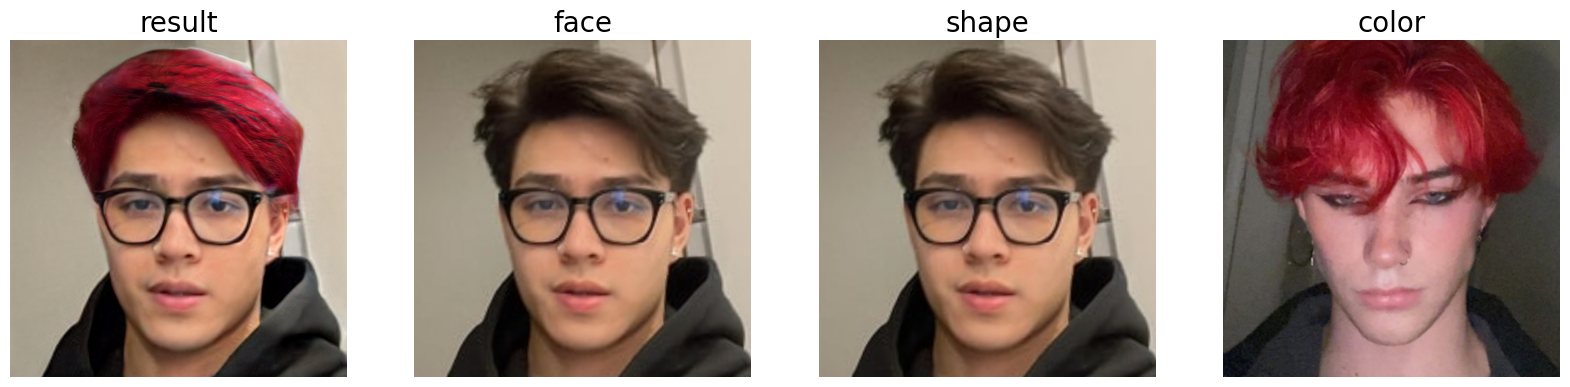

In [ ]:
# @title Inference HairFast { display-mode: "form" }
import argparse
import os
import sys
from pathlib import Path
from PIL import Image

from hair_swap import HairFast, get_parser
from models.Blending import Blending
from utils.image_utils import poisson_image_blending


is_any_url = False


def try_download_image(url):
    is_any_url = True
    try:
        return download_and_convert_to_pil([url])[0]
    except Exception as e:
        print(f"Can't download the image from the link {url}")
        print(e)
        return False


def convert_input(inp):
    if not inp.startswith('http'):
        path = os.path.join(input_path, inp)
        try:
            if os.path.isfile(path):
                if path in path_to_imgs:
                    return path_to_imgs[path]
                else:
                    path_to_imgs[path] = Image.open(path)
                    return path_to_imgs[path]
        except Exception as e:
            print(f"Can't open the image {inp}")
            print(e)
            return False
    else:
        return try_download_image(inp)


if 'hair_fast_instans' not in globals():
    if 'hair_fast' in globals():
        hair_fast_instans = {'Default': hair_fast}
    else:
        model_args = get_parser()
        hair_fast = HairFast(model_args.parse_args([]))
        hair_fast_instans = {'Default': hair_fast}

if 'path_to_imgs' not in globals():
    path_to_imgs = {}


# @markdown Model params
Blending_checkpoint = "Default" # @param ["Default", "Alternative_v1", "Alternative_v2"]
Alignment_images = "Auto"       # @param ["Auto", "On", "Off"]
Poisson_Blending = "On"        # @param ["Off", "On"]
Poissons_iters = 115            # @param {type:"slider", min:50, max:2500, step:1}
Poisson_erossion = 15           # @param {type:"slider", min:1, max:100, step:1}


if Blending_checkpoint not in hair_fast_instans:
    if Blending_checkpoint == 'Alternative_v1':
        new_args = model_args.parse_args(['--blending_checkpoint', 'pretrained_models/Blending/checkpoint_old.pth'])
    elif Blending_checkpoint == 'Alternative_v2':
        new_args = model_args.parse_args(['--blending_checkpoint', 'pretrained_models/Blending/checkpoint_old2.pth'])
    else:
        raise ValueError(f'{Blending_checkpoint} not exist')

    hair_fast_ = copy(hair_fast)
    hair_fast_.blend = Blending(new_args, net=hair_fast_.net)
    hair_fast_instans[Blending_checkpoint] = hair_fast_


# @markdown Input
input_path = "/content/input"    # @param {type:"string"}
face = "a.jpg"                               # @param {type:"string"}
shape = "a.jpg"   # @param {type:"string"}
color = "b.jpg"                              # @param {type:"string"}


converted_inputs = list(map(convert_input, (face, shape, color)))
if all(converted_inputs):
    need_alignment = any(map(lambda img: img.size != (1024, 1024), converted_inputs))

    if Alignment_images == 'On' or Alignment_images == 'Auto' and (need_alignment or is_any_url):
        print('Start alignment', file=sys.stderr)
        result_image, *converted_inputs = hair_fast_instans[Blending_checkpoint](*converted_inputs, align=True)
    else:
        result_image = hair_fast_instans[Blending_checkpoint](*converted_inputs)

    face_obj, shape_obj, color_obj = converted_inputs

    if Poisson_Blending == 'On':
        print('Start poisson blending', file=sys.stderr)
        result_image, _ = poisson_image_blending(result_image, face_obj, dilate_erosion=Poisson_erossion, maxn=Poissons_iters)

    print('Showing results:', file=sys.stderr)
    display_images(result=result_image, face=face_obj, shape=shape_obj, color=color_obj)
elif all((item in globals() for item in ('result_image', 'face_obj', 'shape_obj', 'color_obj'))):
    print('Show old output:', file=sys.stderr)
    display_images(result=result_image, face=face_obj, shape=shape_obj, color=color_obj)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Save result:

In [ ]:
from torchvision.utils import save_image


if isinstance(result_image, torch.Tensor):
    save_image(result_image, '/content/HairFast_result.png')
else:
    result_image.save('/content/HairFast_result.png')

Image.open('/content/HairFast_result.png').resize((512, 512))